(640, 469, 3)
(290, 290, 3)
(250, 200, 3)
(250, 200, 3)
(250, 200, 3)


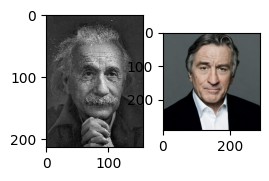

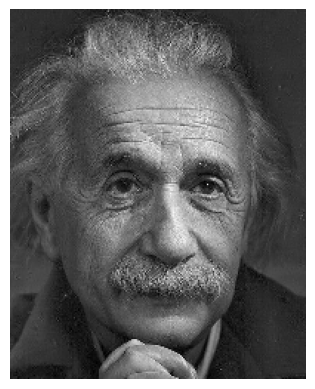

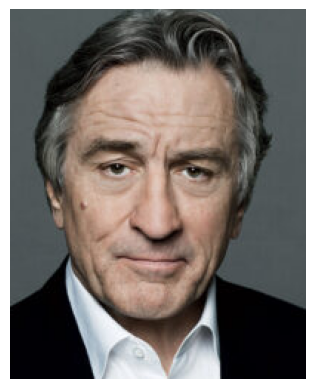

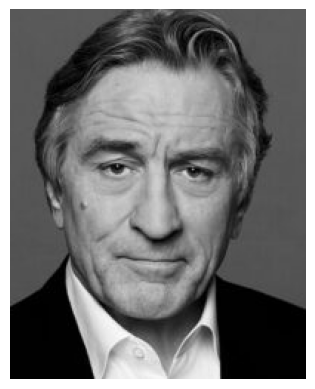

In [1]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance as wd
from lib.collision_wrapper import find_OT_collision as newot
#import ot
#import torch
#from torch import nn, optim

rng = np.random.seed(0)
size = 7;
cm = 0.393701; #inches

import os

# Define the path to your dataset
image_path = './portraits/einstein2.jpg'

#image1 = np.array(Image.open(image_path))
image1 = np.array( Image.open(image_path).convert('L') )
image1 = np.stack((image1,)*3, axis=-1)
print(image1.shape)

image_path = './portraits/RobertDeNiro.jpg'

image2 = np.array(Image.open(image_path))
image2_bw = np.array( Image.open(image_path).convert('L') )
image2_bw = np.stack((image2_bw,)*3, axis=-1)
print(image2_bw.shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(image1[::3,::3,:])
axes[1].imshow(image2)


plt.figure()
im1 = image1.copy()
im1 = im1[50:550,50:450,:]
im1 = im1[::2,::2]
plt.imshow(im1)
plt.axis('off')
fig.set_size_inches(size*cm, size*cm)
plt.savefig('Einstein_bw.pdf',format='pdf', bbox_inches="tight", dpi=300);
print(im1.shape)


plt.figure()
im2 = image2.copy()
im2 = im2[0:250,50:250,:]
plt.imshow(im2)
plt.axis('off')
fig.set_size_inches(size*cm, size*cm)
plt.savefig('DeNiro.pdf',format='pdf', bbox_inches="tight", dpi=300);
print(im2.shape)

plt.figure()
im2_bw = image2_bw.copy()
im2_bw = im2_bw[0:250,50:250,:]
plt.imshow(im2_bw)
plt.axis('off')
fig.set_size_inches(size*cm, size*cm)
plt.savefig('DeNiro_bw.pdf',format='pdf', bbox_inches="tight", dpi=300);
print(im2_bw.shape)


In [2]:
X0 = im2_bw[::2,::2].copy()/256.0
Y0 = im2[::2,::2].copy()/256.0
X = X0.copy()
X = X.reshape(X.shape[0]*X.shape[1],X.shape[2])

Y = Y0.copy()
Y = Y.reshape(Y.shape[0]*Y.shape[1],Y.shape[2])

print(X.shape)
print(Y.shape)

(12500, 3)
(12500, 3)


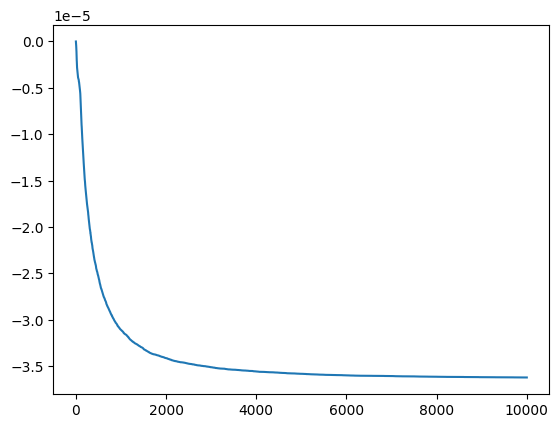

In [4]:
Xt = np.concatenate([X[None,],Y[None,]],axis=0)
Xt, dists0, nt = newot(Xt, MinIter=10000, MaxIter=10000, tol = 1e-9, avg_window=20)

plt.plot(dists0)

In [99]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            #nn.Linear(hidden_dim, hidden_dim),
            #nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.fc(x)
    
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=1))
        return loss


Epoch 1000, Loss: 0.0020719491876661777
Epoch 2000, Loss: 0.0018850183114409447
Epoch 3000, Loss: 0.0018018375849351287
Epoch 4000, Loss: 0.001788063091225922
Epoch 5000, Loss: 0.0017778680194169283


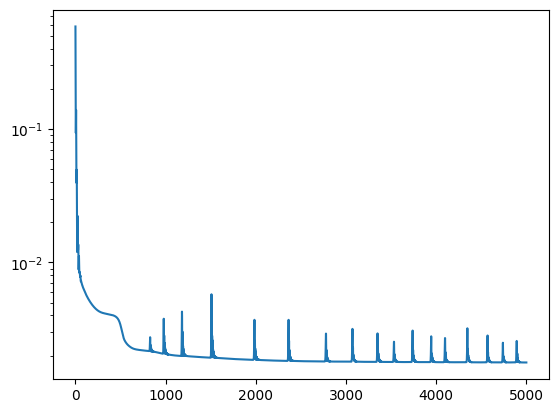

In [112]:
from torch import nn, optim

X = torch.tensor(Xt[0,:], dtype=torch.float32)
Y = torch.tensor(Xt[1,:], dtype=torch.float32)

# Create a simple model and optimizer
model_ocd = Model(input_dim=3)
optimizer = optim.Adam(model_ocd.parameters(), lr=1e-3)

# Training loop
n_epochs = 5000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model_ocd.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model_ocd.eval()

plt.plot(losses)
plt.yscale("log")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


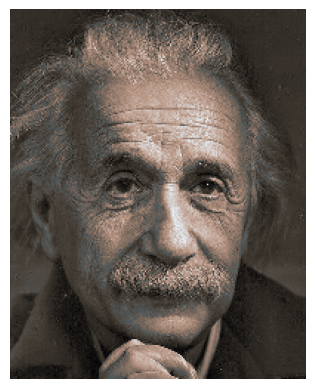

In [115]:
Xtest = im1.reshape(im1.shape[0]*im1.shape[1],im1.shape[2]).copy()/256.0
Xtest = torch.tensor(Xtest, dtype=torch.float32)
Ytest = model_ocd.forward(Xtest)
Ytest = Ytest.detach().numpy()
Ytest = Ytest.reshape(im1.shape[0],im1.shape[1],im1.shape[2])


plt.imshow(Ytest)
plt.axis('off')

fig.set_size_inches(size*cm, size*cm)
plt.savefig('coloredEinstein.pdf',format='pdf', bbox_inches="tight", dpi=300);

#X1 = im1[::2,::2].copy()/256.0
#X1 = X1 + (Xt[1,:] - Xt[0,:]).reshape(Y0.shape[0],Y0.shape[1],Y0.shape[2])
#plt.imshow(X1)

# Noise

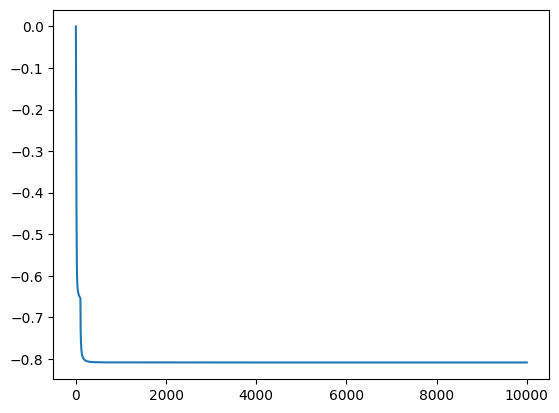

In [5]:
Y = np.random.normal(0,1,X.shape)
Xt = np.concatenate([X[None,],Y[None,]],axis=0)
Xt, dists0, nt = newot(Xt, MinIter=10000, MaxIter=10000, tol = 1e-9, avg_window=20)

plt.plot(dists0)

In [8]:
xt = Xt[0].reshape(X0.shape[0],X0.shape[1],X0.shape[2])

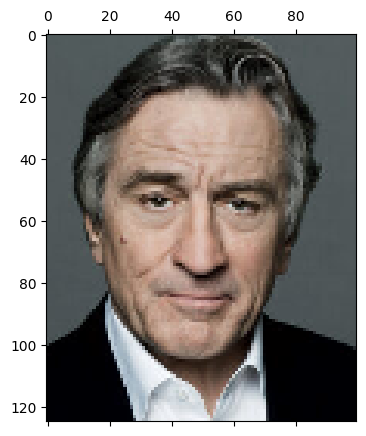

In [20]:
#plt.matshow(X.reshape(X0.shape[0],X0.shape[1],X0.shape[2]))
#plt.matshow(Xt[1].reshape(X0.shape[0],X0.shape[1],X0.shape[2]))
plt.matshow(Y0)

In [21]:
Y0.shape

(125, 100, 3)

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

Xdata, y = mnist["data"], mnist["target"]

Xdata = np.array(Xdata)
print(Xdata.shape)

(70000, 784)


(2, 20000, 784)


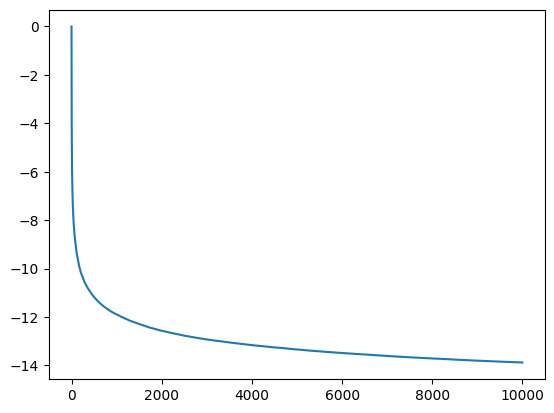

In [14]:
X0 = np.array(Xdata)[:20000] / 256.
Y0 = np.random.normal(0,1,X0.shape) / 3.0

Xt = np.concatenate([X0[None,],Y0[None,]],axis=0)

print(Xt.shape)

Xt, dists0, nt = newot(Xt, MinIter=10000, MaxIter=10000, tol = 1e-9, avg_window=20)

plt.plot(dists0)

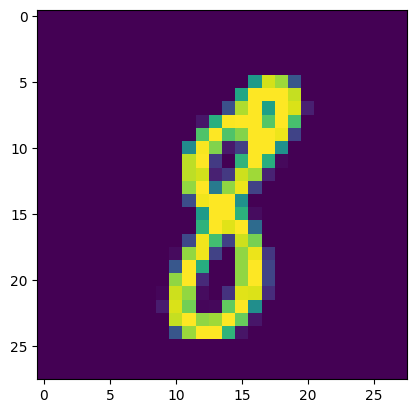

In [35]:
plt.imshow(Xt[0,1,:].reshape(28,28))

In [26]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=200):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.fc(x)
    
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=1))
        return loss


Epoch 100, Loss: 44.756019592285156
Epoch 200, Loss: 71.26805877685547
Epoch 300, Loss: 41.044776916503906
Epoch 400, Loss: 33.03782653808594
Epoch 500, Loss: 27.9348087310791
Epoch 600, Loss: 24.53965187072754
Epoch 700, Loss: 22.733901977539062
Epoch 800, Loss: 19.982357025146484
Epoch 900, Loss: 18.60796546936035
Epoch 1000, Loss: 18.570831298828125
Epoch 1100, Loss: 16.24077033996582
Epoch 1200, Loss: 15.810445785522461
Epoch 1300, Loss: 15.305259704589844
Epoch 1400, Loss: 15.348163604736328
Epoch 1500, Loss: 14.441039085388184
Epoch 1600, Loss: 13.897010803222656
Epoch 1700, Loss: 13.403450012207031
Epoch 1800, Loss: 12.904908180236816
Epoch 1900, Loss: 12.379213333129883
Epoch 2000, Loss: 12.191551208496094
Epoch 2100, Loss: 11.88011360168457
Epoch 2200, Loss: 11.416586875915527
Epoch 2300, Loss: 11.097445487976074
Epoch 2400, Loss: 11.107706069946289
Epoch 2500, Loss: 10.89166259765625
Epoch 2600, Loss: 10.714765548706055
Epoch 2700, Loss: 10.75583267211914
Epoch 2800, Loss: 10

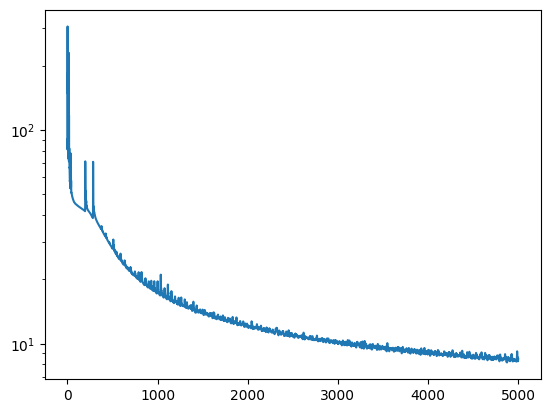

In [27]:
from torch import nn, optim

X = torch.tensor(Xt[1,:,:], dtype=torch.float32)
Y = torch.tensor(Xt[0,:,:], dtype=torch.float32)

# Create a simple model and optimizer
model = Model(input_dim=784)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Training loop
n_epochs = 5000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 100 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model.eval()

plt.plot(losses)
plt.yscale("log")

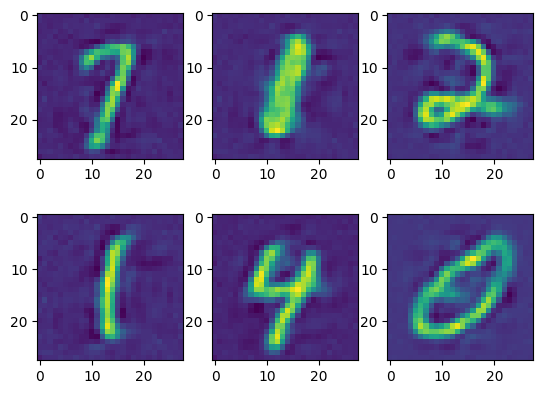

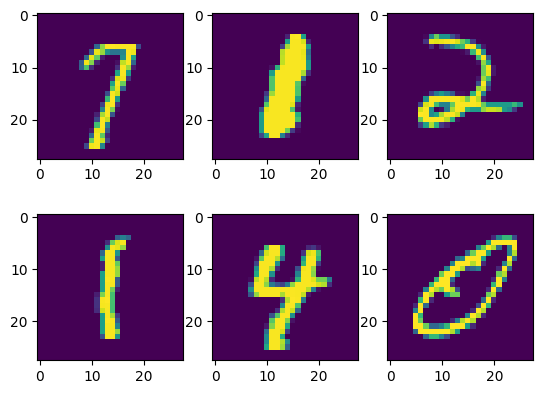

In [46]:
#Xtest = torch.tensor(np.random.normal(0,1,(10,X0.shape[1])), dtype=torch.float32)
#Xtest = torch.tensor(np.random.normal(0,1,X0.shape), dtype=torch.float32)
#Xtest = torch.tensor(np.random.normal(0,1,X0.shape)/3., dtype=torch.float32)
Xtest = torch.tensor(Y0, dtype=torch.float32)

Ytest = model.forward(Xtest)
Ytest = Ytest.detach().numpy()
#print(Ytest.shape)
#Ytest = Ytest.reshape(28,28,1)


fig, axs = plt.subplots(2, 3)
idx = 100

axs[0, 0].imshow(Ytest[idx+0,:].reshape(28,28))
axs[0, 1].imshow(Ytest[idx+1,:].reshape(28,28))
axs[0, 2].imshow(Ytest[idx+2,:].reshape(28,28))

axs[1, 0].imshow(Ytest[idx+3,:].reshape(28,28))
axs[1, 1].imshow(Ytest[idx+4,:].reshape(28,28))
axs[1, 2].imshow(Ytest[idx+5,:].reshape(28,28))


fig, axs = plt.subplots(2, 3)

axs[0, 0].imshow(Y[idx+0,:].reshape(28,28))
axs[0, 1].imshow(Y[idx+1,:].reshape(28,28))
axs[0, 2].imshow(Y[idx+2,:].reshape(28,28))

axs[1, 0].imshow(Y[idx+3,:].reshape(28,28))
axs[1, 1].imshow(Y[idx+4,:].reshape(28,28))
axs[1, 2].imshow(Y[idx+5,:].reshape(28,28))

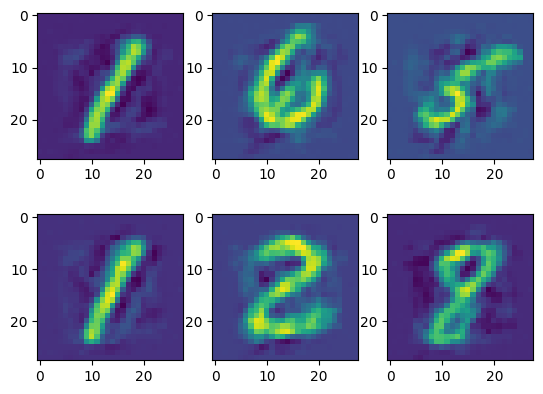

In [40]:
np.max(X0)

255.0

# DDPM

In [47]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)
    


def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    #with imageio.get_writer(gif_name, mode="I") as writer:
    #    for idx, frame in enumerate(frames):
    #        writer.append_data(frame)
    #        if idx == len(frames) - 1:
    #            for _ in range(frames_per_gif // 3):
    #                writer.append_data(frames[-1])
    return x

class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

def _make_te(self, dim_in, dim_out):
  return nn.Sequential(
    nn.Linear(dim_in, dim_out),
    nn.SiLU(),
    nn.Linear(dim_out, dim_out)
  )

class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        #print("t: ", t)
        #print("t.shape: ", t.shape)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [56]:
from torch.utils.data import DataLoader, Subset

subset = Subset(X0[None,:], [i for i in range(1000)])
batch_size = 10
loader = DataLoader(subset, batch_size, shuffle=True)

In [57]:
from torch import nn, optim
from tqdm.auto import tqdm
# Defining model
#device = "cuda"
device = "cpu"
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

optimizer = optim.Adam(ddpm.parameters(), lr=1e-3)
n_epochs = 100

training_loop(ddpm, loader, n_epochs, optimizer, device, display=False, store_path="ddpm_model.pt")

Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

IndexError: index 51 is out of bounds for axis 0 with size 1